## Summary

Using 4 different estimator we can deduce which one perform better in different category. To do that we need to set the same level of standard where the same datasets will be used to fit the estimator and the estimator parameter will be set to default for the first version of the model.

The 4 kind of estimator are as followed:
- Decision Tree
- Random Forest
- KNN
- Naive baiyes
  

## Conclusion

Out of the 4 estimator Random forest perform higher in overal score reaching 98/100 (plus minus) in accuracy, precision, recall and F1 Score. 

the reason why Random forest perform better than the rest is that this estimator can "efficiently" utilize a large set of features by creating numerous decision trees using random set of feature. the trees that are created will then take a vote for which composition perform better on average.

Decision Tree perform slightly worse than random forest while still perform on average higher than 97/100 in all evaluation score. while decision tree only create a single logic tree in comparison to random forest it still perform quite well on a out of sample datasets for this particular case.

While KNN & Naive bayes perform worse in all aspect other than it's precision score. the overal score is still above 90/100 but fall short compare to Decision Trees and Random Forest.

## Import Libraries

Start by loading all the libaries that are needed

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn import tree
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

## Import Datasets

Load the explored datasets, enron represent the legitimate datasets while the other is malicious one 

In [2]:
enron_df = pd.read_csv('datasets/explored/enron-emails-explored.csv')
mal_df = pd.read_csv('datasets/explored/malicious-emails-explored.csv')

In [3]:
print(len(enron_df))
print(len(mal_df))

517401
8129


Create the Training sets by concating the malicious and legitimate datasets and randomized the data 

In [4]:
import random

part_1 = enron_df.sample(8129, ignore_index=True, random_state=1)
part_2 = mal_df
rand = round(random.random())

training_set = (pd.concat([part_1, part_2], ignore_index=True)).sample(frac=1, ignore_index=True, random_state=rand)

bellow is the list of features that can be used to train the model

In [5]:
training_set.columns

Index(['raw_mail', 'subject', 'from', 'to', 'status', 'date', 'body',
       'parsed_from', 'parsed_to', 'parsed_date', 'malicious', 'content_type',
       'charset', 'content_transfer_encoding', 'from_domain', 'to_domain',
       'html', 'javascript', 'css', 'html_form', 'html_iframe',
       'URLs_in_message', 'subject_len', 'subject_entropy', 'body_entropy',
       'attachement', 'enc_content_transfer_encoding', 'enc_content_type',
       'enc_charset'],
      dtype='object')

the potential features that will be used to train the model are shown in the cell bellow

In [6]:
features = [
    'enc_content_type', # encoded category
    'enc_content_transfer_encoding', # encoded category
    'enc_charset', # encoded category
    'html', # if an html page or not
    'javascript', # count of how many javascript file and tag in the email
    'css', # count of how many css file and style tag in the email
    # 'html_form', # count of how many form tag in the email
    # 'html_iframe', # count of how many iframe tag in the email
    'URLs_in_message', # count of how many URLs found in the email 
    # 'subject_len', # lenght of the email subject
    # 'subject_entropy', # the randomness of the email subject
    'body_entropy', # the randomness of the email body
    # 'attachement' # count of how many attachements (e.g. pdf, docx, images and etc)
]

As you can see bellow, all features that are chosen is numeric

In [7]:
training_set[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16258 entries, 0 to 16257
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   enc_content_type               16258 non-null  int64  
 1   enc_content_transfer_encoding  16258 non-null  int64  
 2   enc_charset                    16258 non-null  int64  
 3   html                           16258 non-null  int64  
 4   javascript                     16258 non-null  int64  
 5   css                            16258 non-null  int64  
 6   URLs_in_message                16258 non-null  int64  
 7   body_entropy                   16258 non-null  float64
dtypes: float64(1), int64(7)
memory usage: 1016.2 KB


## Spliting the training sets

the training sets are split into 2, training and validation.

the training set will contains 15000 row and validation set will contains 5000 row, with a ratio to 3:1

In [8]:
X = training_set[features]
X = X.bfill().ffill()
y = training_set.malicious

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = rand)

print("train lenght: ",len(train_X))
print("val lenght: ",len(val_X))

train lenght:  12193
val lenght:  4065


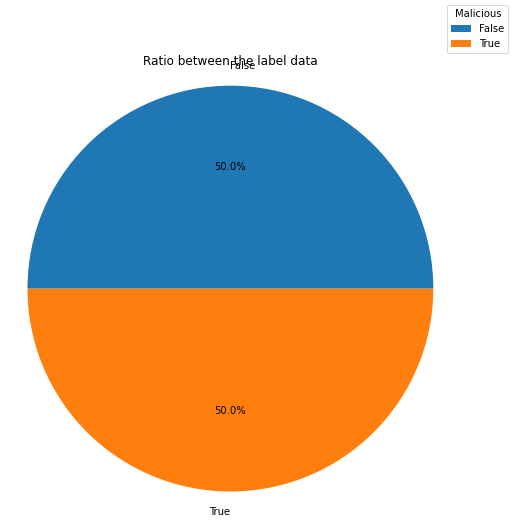

In [9]:
df = training_set.groupby('malicious').size()

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(df.values, labels=df.index, autopct='%1.1f%%')
ax.axis('equal')
fig.set_facecolor('white')
fig.legend(df.index, title="Malicious")

plt.title("Ratio between the label data")
plt.show()


A summary of the aggregate values for the dataset can be found bellow

In [10]:
X.describe()

,enc_content_type,enc_content_transfer_encoding,enc_charset,html,javascript,css,URLs_in_message,body_entropy
count,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000,16258.000000
mean,1.771374,1.148604,1.916410,0.132735,0.195658,0.097183,3.138516,4.813841
std,1.236086,1.069837,3.605964,0.339298,1.599398,0.477999,9.397930,0.499042
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.562683
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.819080
75%,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,5.077794
max,5.000000,5.000000,26.000000,1.000000,95.000000,14.000000,127.000000,6.134659


## Features selections

In [11]:
selector = SelectFromModel(estimator=RandomForestClassifier())
selector = selector.fit(X, y)

In [12]:
selector.threshold_

0.125

Best perfoming features for randomforest

In [13]:
support = selector.get_support()
f_s = pd.Series(features)
f_s[support]

0                 enc_content_type
1    enc_content_transfer_encoding
2                      enc_charset
dtype: object

# Model training

the model that will be train will used 4 different kind algorithm, which are:
- Decision Tree
- Random forest
- KNN
- Naive baiyes

the purpose of training different model is to make the comparison of the said algorithms, to find which produce model with better overal performance and to see which model perform better in one aspect

Define Cross validation function

In [14]:
def getCV(model):
    scores = cross_val_score(model, X, y, cv=10)
    scores = pd.Series(scores)
    print(scores)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.bar(scores.index, scores)
    ax.set_xlabel("Cross validation step")
    ax.set_ylabel("Score")
    plt.show()

## Decision Tree

Define the model and fit the model with the training data

In [15]:
dts_clf = DecisionTreeClassifier(
    random_state=rand)

dts_model = dts_clf.fit(train_X, train_y)

### Train result

Number of mislabeled points out of a total: 12193 points: 0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6129
        True       1.00      1.00      1.00      6064

    accuracy                           1.00     12193
   macro avg       1.00      1.00      1.00     12193
weighted avg       1.00      1.00      1.00     12193



<AxesSubplot:>

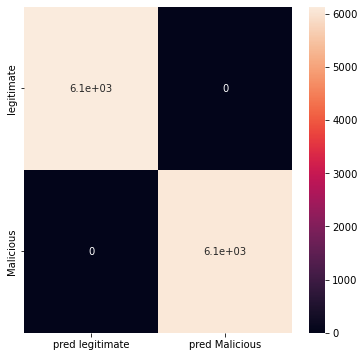

In [16]:
pred_y = dts_model.predict(train_X)

print(f"Number of mislabeled points out of a total: {len(train_X)} points: {(train_y != pred_y).sum()}")
print(classification_report(train_y, pred_y))

cm = confusion_matrix(train_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=['pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6,6))
sn.heatmap(df_cm, annot=True)

### Validation result

Number of mislabeled points out of a total: 4065 points: 101
              precision    recall  f1-score   support

       False       0.98      0.97      0.97      2000
        True       0.97      0.98      0.98      2065

    accuracy                           0.98      4065
   macro avg       0.98      0.98      0.98      4065
weighted avg       0.98      0.98      0.98      4065



<AxesSubplot:>

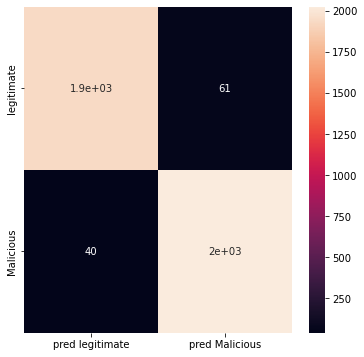

In [17]:
pred_y = dts_model.predict(val_X)

print(f"Number of mislabeled points out of a total: {len(val_X)} points: {(val_y != pred_y).sum()}")
print(classification_report(val_y, pred_y))

cm = confusion_matrix(val_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=[
                     'pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6, 6))
sn.heatmap(df_cm, annot=True)


Cross validate 10 step to see if the model is overfitted or underfitted or fit

0    0.974170
1    0.978475
2    0.974170
3    0.974785
4    0.974170
5    0.973555
6    0.979090
7    0.972325
8    0.969231
9    0.977846
dtype: float64


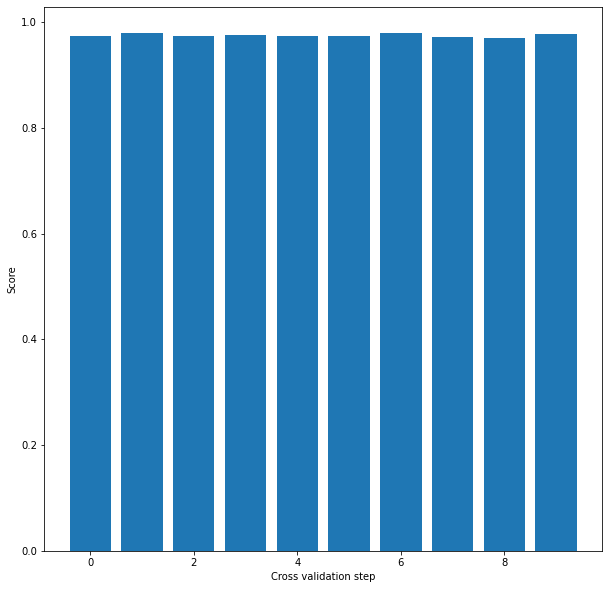

In [18]:
getCV(dts_model)

Display the tree structure that the model created

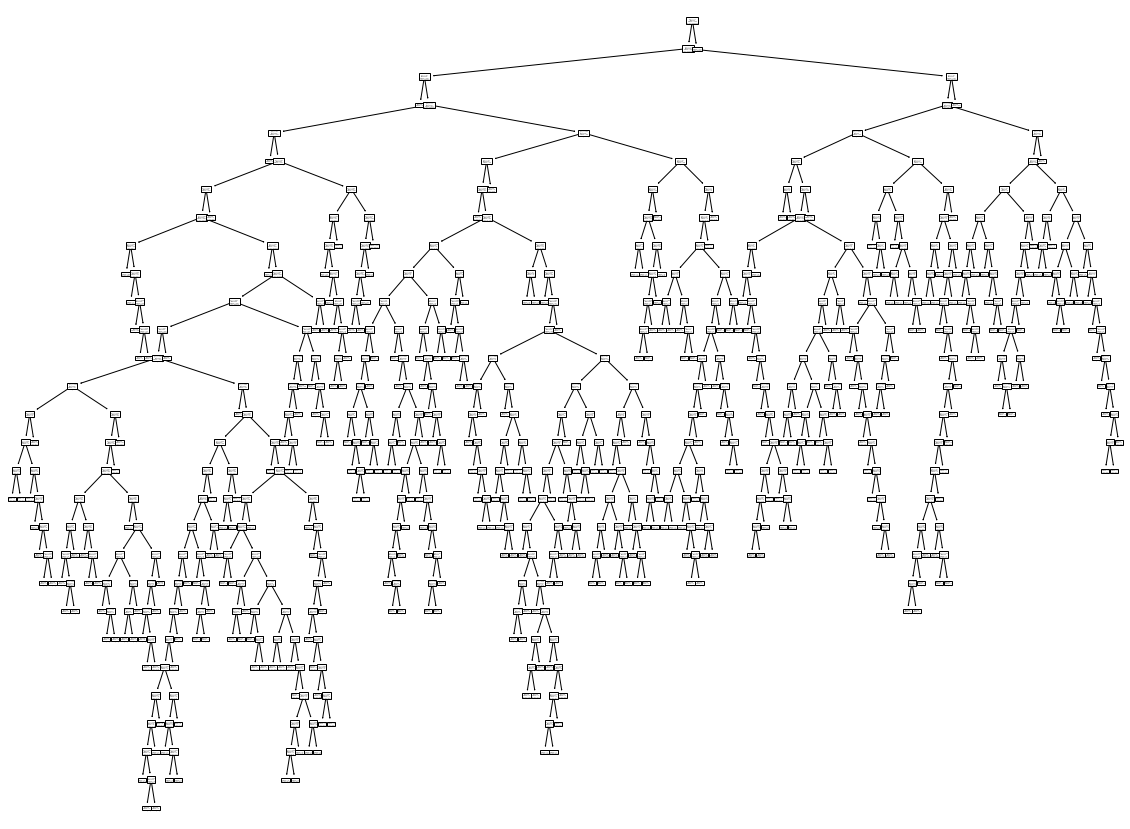

In [19]:
fig = plt.figure(figsize=(20, 15))
tree.plot_tree(dts_model)
plt.show()

### Bruteforce hypertuning with GridsearchCV for decision Tree

In [20]:
rng = 100
best_dt_cls = DecisionTreeClassifier()

parameters = {
    'max_depth': [round(random.random() * 100) for i in range(0, rng)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

gs_cv = GridSearchCV(
    estimator=best_dt_cls,
    param_grid=parameters,
    cv=5,
    n_jobs=4,
    verbose=4)

gs_cv_model = gs_cv.fit(train_X, train_y)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


In [21]:
gs_cv_model.best_params_

{'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'auto',
 'splitter': 'random'}

Number of mislabeled points out of a total: 4065 points: 76
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      2000
        True       0.98      0.98      0.98      2065

    accuracy                           0.98      4065
   macro avg       0.98      0.98      0.98      4065
weighted avg       0.98      0.98      0.98      4065



<AxesSubplot:>

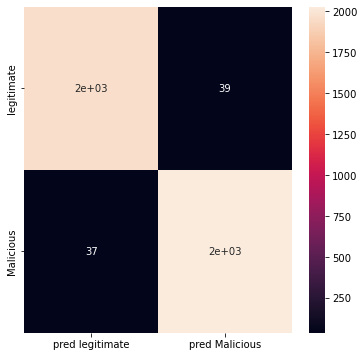

In [22]:
pred_y = gs_cv_model.predict(val_X)

print(f"Number of mislabeled points out of a total: {len(val_X)} points: {(val_y != pred_y).sum()}")
print(classification_report(val_y, pred_y))

cm = confusion_matrix(val_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=[
                     'pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6, 6))
sn.heatmap(df_cm, annot=True)

In [23]:
best_dt_cls = DecisionTreeClassifier(
    criterion=gs_cv_model.best_params_['criterion'],
    max_depth=gs_cv_model.best_params_['max_depth'],
    splitter=gs_cv_model.best_params_['splitter'],
    max_features=gs_cv_model.best_params_['max_features']
)

best_dts_model = best_dt_cls.fit(train_X, train_y)

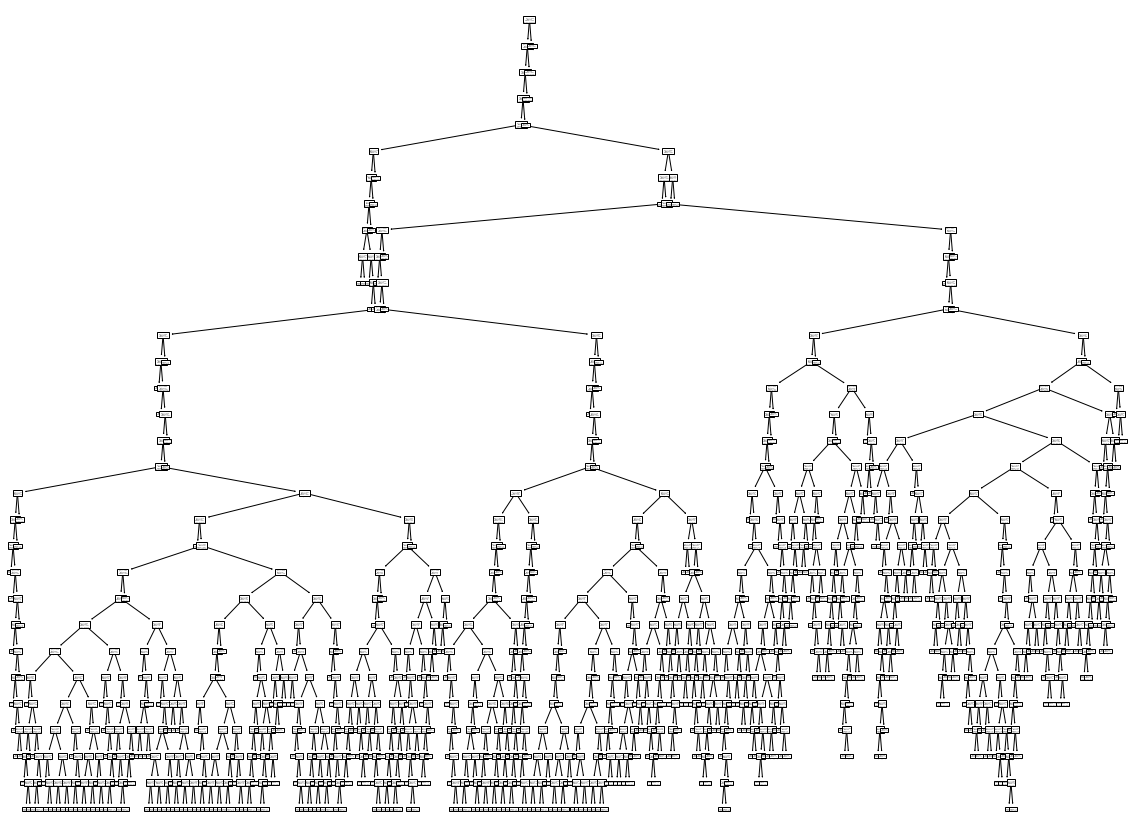

In [24]:
fig = plt.figure(figsize=(20, 15))
tree.plot_tree(best_dts_model)
plt.show()

## KNN

In [25]:
knn_clf = KNeighborsClassifier()
knn_model = knn_clf.fit(train_X, train_y)

### Train result

Number of mislabeled points out of a total: 12193 points: 218
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      6129
        True       0.99      0.98      0.98      6064

    accuracy                           0.98     12193
   macro avg       0.98      0.98      0.98     12193
weighted avg       0.98      0.98      0.98     12193



<AxesSubplot:>

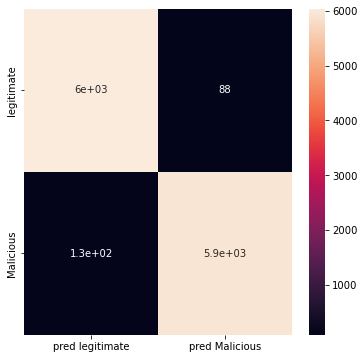

In [26]:
pred_y = knn_model.predict(train_X)

print(f"Number of mislabeled points out of a total: {len(train_X)} points: {(train_y != pred_y).sum()}")
print(classification_report(train_y, pred_y))

cm = confusion_matrix(train_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=['pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6,6))
sn.heatmap(df_cm, annot=True)

### Validation result

Number of mislabeled points out of a total: 4065 points: 99
              precision    recall  f1-score   support

       False       0.98      0.97      0.98      2000
        True       0.97      0.98      0.98      2065

    accuracy                           0.98      4065
   macro avg       0.98      0.98      0.98      4065
weighted avg       0.98      0.98      0.98      4065



<AxesSubplot:>

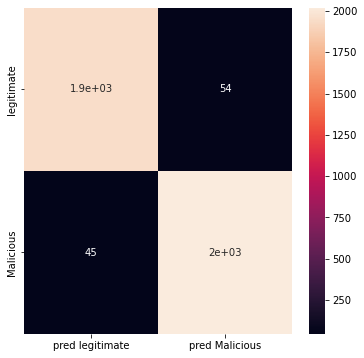

In [27]:
pred_y = knn_model.predict(val_X)

print(
    f"Number of mislabeled points out of a total: {len(val_X)} points: {(val_y != pred_y).sum()}")
print(classification_report(val_y, pred_y))

cm = confusion_matrix(val_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=[
                     'pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6, 6))
sn.heatmap(df_cm, annot=True)


### Cross validation result

0    0.972940
1    0.980935
2    0.980935
3    0.975400
4    0.972940
5    0.977860
6    0.980320
7    0.971710
8    0.971692
9    0.979077
dtype: float64


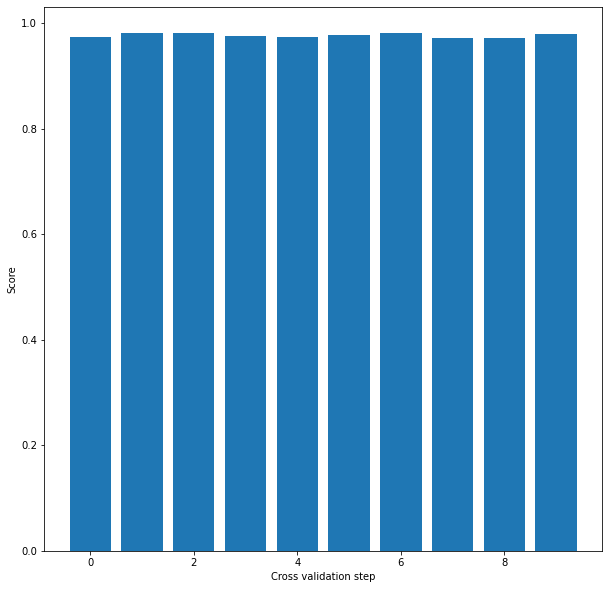

In [28]:
getCV(knn_model)

## Random Forest

In [29]:
rf_clf = RandomForestClassifier(random_state=rand)

rf_model = rf_clf.fit(train_X, train_y)

### train result

Number of mislabeled points out of a total: 12193 points: 0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      6129
        True       1.00      1.00      1.00      6064

    accuracy                           1.00     12193
   macro avg       1.00      1.00      1.00     12193
weighted avg       1.00      1.00      1.00     12193



<AxesSubplot:>

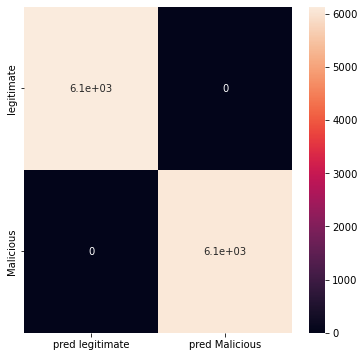

In [30]:
pred_y = rf_model.predict(train_X)

print(f"Number of mislabeled points out of a total: {len(train_X)} points: {(train_y != pred_y).sum()}")
print(classification_report(train_y, pred_y))

cm = confusion_matrix(train_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=['pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6,6))
sn.heatmap(df_cm, annot=True)

### Validation result

Number of mislabeled points out of a total: 4065 points: 92
              precision    recall  f1-score   support

       False       0.98      0.97      0.98      2000
        True       0.97      0.98      0.98      2065

    accuracy                           0.98      4065
   macro avg       0.98      0.98      0.98      4065
weighted avg       0.98      0.98      0.98      4065



<AxesSubplot:>

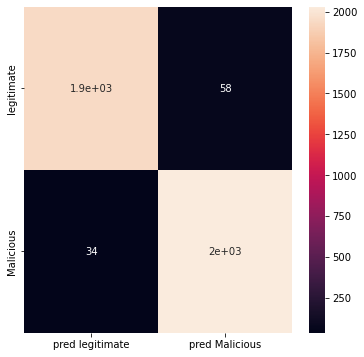

In [31]:
pred_y = rf_model.predict(val_X)

print(f"Number of mislabeled points out of a total: {len(val_X)} points: {(val_y != pred_y).sum()}")
print(classification_report(val_y, pred_y))

cm = confusion_matrix(val_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=['pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6,6))
sn.heatmap(df_cm, annot=True)

### Cross validation result

0    0.973555
1    0.979705
2    0.974170
3    0.974785
4    0.972325
5    0.973555
6    0.979090
7    0.975400
8    0.970462
9    0.979692
dtype: float64


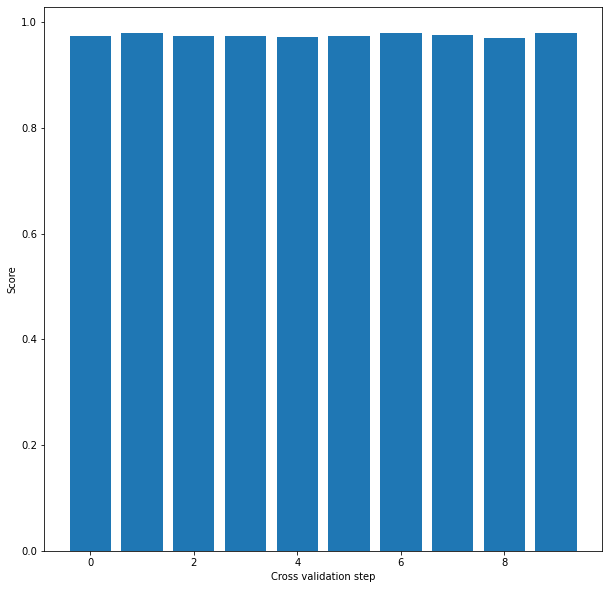

In [32]:
getCV(rf_model)

### Trainning with KFold Cross validation

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

k = 10
kf = KFold(n_splits=k, random_state=None)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    rf_clf.fit(X_train,y_train)
    pred_values = rf_clf.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.9735547355473555, 0.9784747847478474, 0.9760147601476015, 0.9735547355473555, 0.9723247232472325, 0.972939729397294, 0.9784747847478474, 0.9747847478474785, 0.9692307692307692, 0.9790769230769231]
Avg accuracy : 0.9748430693537704


### Randomforest Gridsearch hyper-tuning

Bruteforce hyper parameter tuning with Gridsearch and crossvalidate

In [34]:
rng = 5

best_rf_cls = RandomForestClassifier()

parameters = {
        'n_estimators': [round(random.random() * 100) for i in range(0, rng)],
        'max_depth': [round(random.random() * 100) for i in range(0, rng)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion': ['gini', 'entropy']
}

gs_cv = GridSearchCV(
        estimator=best_rf_cls,
        param_grid=parameters,
        cv=5,
        n_jobs=4,
        verbose=4)

gs_cv_model = gs_cv.fit(train_X, train_y)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


In [35]:
gs_cv_model.best_params_

{'criterion': 'gini',
 'max_depth': 38,
 'max_features': 'sqrt',
 'n_estimators': 31}

Testing the best parameter with the validation set

Number of mislabeled points out of a total: 4065 points: 94
              precision    recall  f1-score   support

       False       0.98      0.97      0.98      2000
        True       0.97      0.98      0.98      2065

    accuracy                           0.98      4065
   macro avg       0.98      0.98      0.98      4065
weighted avg       0.98      0.98      0.98      4065



<AxesSubplot:>

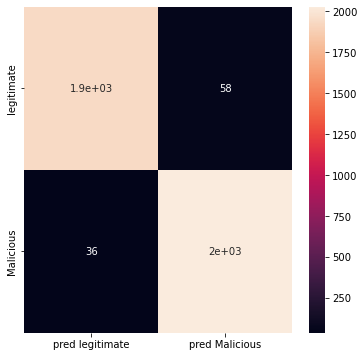

In [36]:
pred_y = gs_cv_model.predict(val_X)

print(f"Number of mislabeled points out of a total: {len(val_X)} points: {(val_y != pred_y).sum()}")
print(classification_report(val_y, pred_y))

cm = confusion_matrix(val_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=['pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6,6))
sn.heatmap(df_cm, annot=True)

## Naive Bayes

In [37]:
nb_clf = GaussianNB()
nb_model = nb_clf.fit(train_X, train_y)

### Train result

Number of mislabeled points out of a total: 4065 points: 389
              precision    recall  f1-score   support

       False       0.84      0.99      0.91      2000
        True       0.99      0.82      0.90      2065

    accuracy                           0.90      4065
   macro avg       0.92      0.91      0.90      4065
weighted avg       0.92      0.90      0.90      4065



<AxesSubplot:>

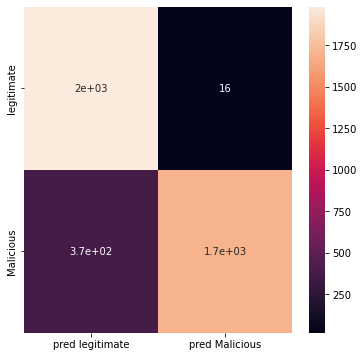

In [38]:
pred_y = nb_model.predict(val_X)

print(
    f"Number of mislabeled points out of a total: {len(val_X)} points: {(val_y != pred_y).sum()}")
print(classification_report(val_y, pred_y))

cm = confusion_matrix(val_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=[
                     'pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6, 6))
sn.heatmap(df_cm, annot=True)


### Validation result

Number of mislabeled points out of a total: 4065 points: 389
              precision    recall  f1-score   support

       False       0.84      0.99      0.91      2000
        True       0.99      0.82      0.90      2065

    accuracy                           0.90      4065
   macro avg       0.92      0.91      0.90      4065
weighted avg       0.92      0.90      0.90      4065



<AxesSubplot:>

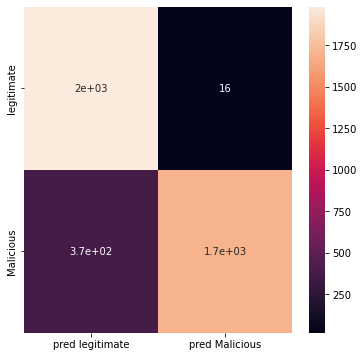

In [43]:
pred_y = nb_model.predict(val_X)

print(f"Number of mislabeled points out of a total: {len(val_y)} points: {(val_y != pred_y).sum()}")
print(classification_report(val_y, pred_y))

cm = confusion_matrix(val_y, pred_y)
df_cm = pd.DataFrame(cm, index=['legitimate', 'Malicious'], columns=['pred legitimate', 'pred Malicious'])

plt.figure(figsize=(6,6))
sn.heatmap(df_cm, annot=True)

0    0.906519
1    0.915744
2    0.908364
3    0.907134
4    0.904059
5    0.907749
6    0.914514
7    0.905289
8    0.906462
9    0.913231
dtype: float64


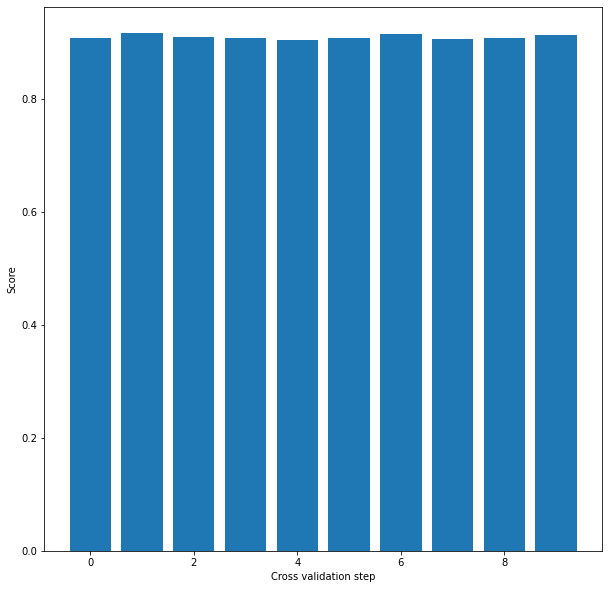

In [44]:
getCV(nb_model)

## Receiver operating characteristic - TP/FP rate

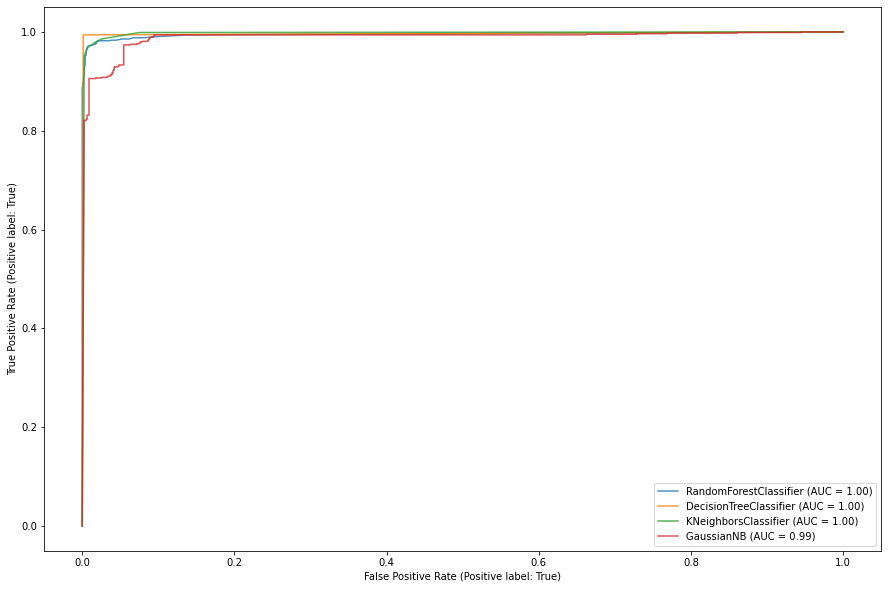

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))

rfc_disp = RocCurveDisplay.from_estimator(
    rf_clf, X_test, y_test, alpha=0.8, ax=ax)
dts_disp = RocCurveDisplay.from_estimator(
    dts_clf, X_test, y_test, alpha=0.8, ax=ax)
knn_disp = RocCurveDisplay.from_estimator(
    knn_clf, X_test, y_test, alpha=0.8, ax=ax)
nb_disp = RocCurveDisplay.from_estimator(
    nb_clf, X_test, y_test, alpha=0.8, ax=ax)

## (Alternative) Test Cycle

The function bellow test how much of effect does mixing does to the model evaluation results

the datasets mixing is done using a random number as the seed

the results of the test then save into a file 

In [46]:
def test_cycle(cycle):
    temp = {}
    for i in range(cycle):
        data = { }
        part_1 = enron_df.sample(11871, ignore_index=True, random_state=1) ## get the same data each time
        part_2 = mal_df
        rand = round(random.random() * 10000)
        data["rand"] = rand
        
        training_set = (pd.concat([part_1, part_2], ignore_index=True)).sample(frac=1, ignore_index=True, random_state=rand)
        
        X = training_set[features]
        y = training_set.malicious
        train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = rand)
        
        dts_clf = DecisionTreeClassifier(random_state=rand)
        dts_model = dts_clf.fit(train_X, train_y)
        pred_y = dts_model.predict(val_X)
        data["dts_accuracy"] = round((val_y == pred_y).sum() / len(val_X) * 100)
        data["dts_precision"] = round(precision_score(val_y, pred_y) * 100)
        data["dts_recall"] = round(recall_score(val_y, pred_y) * 100)
        data["dts_recall"] = round(recall_score(val_y, pred_y) * 100)
        data["dts_f1"] = round(f1_score(val_y, pred_y) * 100)
        
        knn_clf = KNeighborsClassifier()
        knn_model = knn_clf.fit(train_X, train_y)
        pred_y = knn_model.predict(val_X)
        data["knn_accuracy"] = round((val_y == pred_y).sum() / len(val_X) * 100)
        data["knn_precision"] = round(precision_score(val_y, pred_y) * 100)
        data["knn_recall"] = round(recall_score(val_y, pred_y) * 100)
        data["knn_recall"] = round(recall_score(val_y, pred_y) * 100)
        data["knn_f1"] = round(f1_score(val_y, pred_y) * 100)
        
        rf_clf = RandomForestClassifier(random_state=rand)
        rf_model = rf_clf.fit(train_X, train_y)
        pred_y = rf_model.predict(val_X)
        data["rf_accuracy"] = round((val_y == pred_y).sum() / len(val_X) * 100)
        data["rf_precision"] = round(precision_score(val_y, pred_y) * 100)
        data["rf_recall"] = round(recall_score(val_y, pred_y) * 100)
        data["rf_recall"] = round(recall_score(val_y, pred_y) * 100)
        data["rf_f1"] = round(f1_score(val_y, pred_y) * 100)
        
        nb_clf = GaussianNB()
        nb_model = nb_clf.fit(train_X, train_y)
        pred_y = nb_model.predict(val_X)   
        data["nb_accuracy"] = round((val_y == pred_y).sum() / len(val_X) * 100)
        data["nb_precision"] = round(precision_score(val_y, pred_y) * 100)
        data["nb_recall"] = round(recall_score(val_y, pred_y) * 100)
        data["nb_recall"] = round(recall_score(val_y, pred_y) * 100)
        data["nb_f1"] = round(f1_score(val_y, pred_y) * 100)
        
        temp[i] = data
    return temp

### saving test results

In [47]:
import json

with open('./datasets/test-result.json', 'w') as fs:
    fs.writelines(json.dumps(test_cycle(100)))   

In [48]:
test_df = pd.read_json('./datasets/test-result.json', orient="index")

In [49]:
test_df.describe()

,rand,dts_accuracy,dts_precision,dts_recall,dts_f1,knn_accuracy,knn_precision,knn_recall,knn_f1,rf_accuracy,rf_precision,rf_recall,rf_f1,nb_accuracy,nb_precision,nb_recall,nb_f1
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.00
mean,4331.710000,97.690000,96.830000,97.200000,96.990000,97.92000,97.620000,96.860000,97.160000,97.85000,97.010000,97.220000,97.040000,92.510000,98.970000,82.44000,89.95
std,2816.271725,0.464823,0.472582,0.426401,0.173787,0.27266,0.487832,0.512865,0.368453,0.35887,0.460457,0.439927,0.242878,0.502418,0.222702,0.80804,0.50
min,27.000000,97.000000,96.000000,96.000000,96.000000,97.00000,97.000000,96.000000,97.000000,97.00000,96.000000,96.000000,96.000000,92.000000,98.000000,80.00000,89.00
25%,1699.500000,97.000000,97.000000,97.000000,97.000000,98.00000,97.000000,97.000000,97.000000,98.00000,97.000000,97.000000,97.000000,92.000000,99.000000,82.00000,90.00
50%,4058.000000,98.000000,97.000000,97.000000,97.000000,98.00000,98.000000,97.000000,97.000000,98.00000,97.000000,97.000000,97.000000,93.000000,99.000000,82.00000,90.00
75%,6449.000000,98.000000,97.000000,97.000000,97.000000,98.00000,98.000000,97.000000,97.000000,98.00000,97.000000,97.000000,97.000000,93.000000,99.000000,83.00000,90.00
max,9669.000000,98.000000,98.000000,98.000000,98.000000,98.00000,98.000000,98.000000,98.000000,98.00000,98.000000,98.000000,98.000000,93.000000,100.000000,84.00000,91.00
